# Calculation of volumetric rates
In the note I will discuss how I calculate the and verify the calculation of the volumetric rates. I am a bit uncertainty to why exactly it works. I will discuss this in the end of the document.

## Initialise session and loading data

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os

from pseudobatch import pseudobatch_transform_pandas, reverse_pseudobatch_transform_pandas
from pseudobatch.datasets import load_product_inhibited_fedbatch

In the following I load the example data substrate inhibited fed-batch processes and calculate the pseudo batch transformed values.

In [20]:
fedbatch_df = load_product_inhibited_fedbatch()
glucose_in_feed = fedbatch_df.s_f.iloc[0]

fedbatch_df[["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo", "c_CO2_pseudo"]] = pseudobatch_transform_pandas(
    fedbatch_df,
    measured_concentration_colnames=["c_Biomass", "c_Glucose", "c_Product", "c_CO2"],
    reactor_volume_colname="v_Volume",
    accumulated_feed_colname="v_Feed_accum",
    sample_volume_colname="sample_volume",
    concentration_in_feed=[0, glucose_in_feed, 0, 0],
)

First I calculate the true volumetric rates from the simulated data, this is done using the following equation.

$$
q_{species}(t) = \mu(t) * C_{Biomass}(t) * Y_{BiomassSpecies}
$$

where $q_{species}(t)$ is the true volumetric rate, $\mu(t)$ is the true specific growth rate simulated using substrate inhibited monod kinetics, $C_{Biomass}(t)$ is the concentration of biomass and $Y_{BiomassSpecies}$ is the yield coefficient of the given species with respect to biomass ($\frac{gSpecies}{gBiomass}$). The yield coefficients were constant during the simulation. The following code calculated the true volumetric rates.

In [21]:
# true volumetric rates
true_volumetric_rates = fedbatch_df.filter(['timestamp']).copy()

true_volumetric_rates['q_biomass'] = fedbatch_df.mu_true * fedbatch_df.c_Biomass
true_volumetric_rates['q_glucose'] = fedbatch_df.mu_true * fedbatch_df.c_Biomass * -1*fedbatch_df.Yxs # negative bacause glucose is consumed
true_volumetric_rates['q_product'] = fedbatch_df.mu_true * fedbatch_df.c_Biomass * fedbatch_df.Yxp
true_volumetric_rates['q_co2'] = fedbatch_df.mu_true * fedbatch_df.c_Biomass * fedbatch_df.Yxco2

The goal is to estimate $q_{species}(t)$. Note that in this verification example I will use all the simulated data, i.e. not only the sampling points.


In a batch reactor $\frac{dC_{species}}{dt}=q_{species}$, thus in the pseudo batch reactor the following should be valid:

$$
q^{\star}_{species} = \frac{dC_{species}^{\star}}{dt}
$$

Here $q^{\star}_{species}$ is the volumetric rate in "pseudo space". Thus we need to estimate $\frac{dC_{species}^{\star}}{dt}$. Here I will use finite differences as it is easy. In the following I create a small function wraps the function `np.gradient()` which deploys a second order centered finite difference method to estimate the first order derivative.

In [22]:
def finite_difference_derivative(df: pd.DataFrame, x_colname: str, y_colname: str, log_transform_y: bool = False)->np.ndarray:
    x = df[x_colname].to_numpy()
    if log_transform_y:
        y = df[y_colname].transform(np.log).to_numpy()
    else:
        y = df[y_colname].to_numpy()
    return np.gradient(y, x)

Now I can estimate $q^{\star}_{species}$ for all the four species.

In [23]:
fedbatch_df['q_star_biomass'] = finite_difference_derivative(fedbatch_df, "timestamp", "c_Biomass_pseudo", log_transform_y=False)
fedbatch_df['q_star_glucose'] = finite_difference_derivative(fedbatch_df, "timestamp", "c_Glucose_pseudo", log_transform_y=False) 
fedbatch_df['q_star_product'] = finite_difference_derivative(fedbatch_df, "timestamp", "c_Product_pseudo", log_transform_y=False)
fedbatch_df['q_star_co2'] = finite_difference_derivative(fedbatch_df, "timestamp", "c_CO2_pseudo", log_transform_y=False)

The $q^{\star}_{species}$ does not match the true volumetric rate. Here I illustrate it only using the biomass rate.

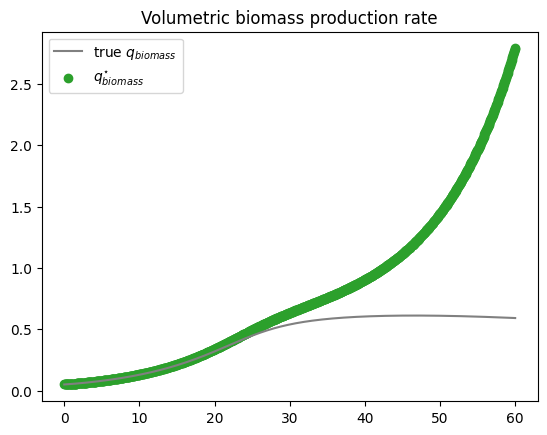

In [24]:
plt.plot(true_volumetric_rates["timestamp"], true_volumetric_rates["q_biomass"], label=r"true $q_{biomass}$", color="grey")
plt.scatter(fedbatch_df["timestamp"], fedbatch_df['q_star_biomass'], color = "C2", label=r"$q^{\star}_{biomass}$")
plt.title("Volumetric biomass production rate")
plt.legend()

It is clear that $q^{\star}_{species} \neq q_{species}$. But, I have found that the following transformation obtains the correct value.

$$
q^{\star}_{species} * ADF^{-1} = q_{species}
$$
where $ADF$ is the accumulated dilution factor. In the following code chunks I calculate ADF, apply the transformation to calculate the $q_{species}$ estimates, and visualize the results.

In [25]:
from pseudobatch import accumulated_dilution_factor

adf = accumulated_dilution_factor(
    after_sample_reactor_volume=fedbatch_df.v_Volume - fedbatch_df.sample_volume,
    sample_volume=fedbatch_df.sample_volume
)


In [26]:
fedbatch_df['q_biomass'] = fedbatch_df.q_star_biomass / adf
fedbatch_df['q_glucose'] = fedbatch_df.q_star_glucose / adf
fedbatch_df['q_product'] = fedbatch_df.q_star_product / adf
fedbatch_df['q_co2'] = fedbatch_df.q_star_co2 / adf

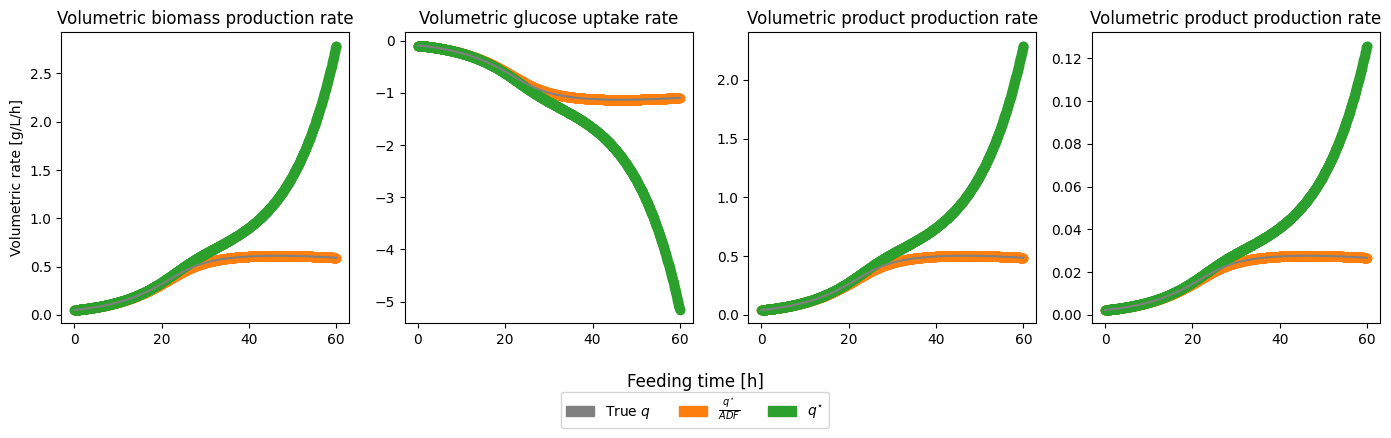

In [30]:
# Plot the results
import matplotlib.patches as mpatches
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(14, 4))
axes[0].plot(true_volumetric_rates["timestamp"], true_volumetric_rates["q_biomass"], label="Simulated glucose uptake rate", color="grey")
axes[0].scatter(fedbatch_df["timestamp"], fedbatch_df['q_biomass'], color = "C1")
axes[0].scatter(fedbatch_df["timestamp"], fedbatch_df['q_star_biomass'], color = "C2")
axes[0].set_title("Volumetric biomass production rate")

axes[1].plot(true_volumetric_rates["timestamp"], true_volumetric_rates["q_glucose"], color="grey")
axes[1].scatter(fedbatch_df["timestamp"], fedbatch_df['q_glucose'], color = "C1")
axes[1].scatter(fedbatch_df["timestamp"], fedbatch_df['q_star_glucose'], color = "C2")
axes[1].set_title("Volumetric glucose uptake rate")

axes[2].plot(true_volumetric_rates["timestamp"], true_volumetric_rates["q_product"], color="grey")
axes[2].scatter(fedbatch_df["timestamp"], fedbatch_df['q_product'], color = "C1")
axes[2].scatter(fedbatch_df["timestamp"], fedbatch_df['q_star_product'], color = "C2")
axes[2].set_title("Volumetric product production rate")

axes[3].plot(true_volumetric_rates["timestamp"], true_volumetric_rates["q_co2"], color="grey")
axes[3].scatter(fedbatch_df["timestamp"], fedbatch_df['q_co2'], color = "C1")
axes[3].scatter(fedbatch_df["timestamp"], fedbatch_df['q_star_co2'], color = "C2")
axes[3].set_title("Volumetric product production rate")

# setup legend
true_patch = mpatches.Patch(color='grey', label=r'True $q$')
pseudo_patch = mpatches.Patch(color='C1', label=r'$\frac{q^{\star}}{ADF}$')
pseudo_star_patch = mpatches.Patch(color='C2', label=r'$q^{\star}$')

fig.supxlabel("Feeding time [h]")
axes[0].set_ylabel("Volumetric rate [g/L/h]")
fig.legend(
    handles=[true_patch, pseudo_patch, pseudo_star_patch],
    loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.1)
)
fig.tight_layout()

The plot clearly show that the methods works to obtain the correct volumetric rates, but I am a bit uncertainty to why it works and I cannot come up with a formal argument.

The method is based on reversing the pseudo batch transformation (just isolating concentration instead of the pseudo batch concentration in pseudo batch transformation equation):

$$
C^{\star}_k  = C_k * ADF_k - \sum_{i=1}^{k-1}ADF_i\frac{C_{feed}^{species}\cdot 
        F_{i}}{V_i}\iff
\frac{C^{\star}_k}{ADF_k} + \frac{\sum_{i=1}^{k-1}ADF_i\frac{C_{feed}^{species}\cdot 
        F_{i}}{V_i}}{ADF_k} = C_k
$$

Then replacing the concentration with the volumetric rate
$$
\frac{q^{\star}_k}{ADF_k} + \frac{\sum_{i=1}^{k-1}ADF_i\frac{C_{feed}^{species}\cdot 
        F_{i}}{V_i}}{ADF_k} = q_k
$$
If then the second term is set to 0 we have the equation, but I'm not too happy with this derivation. 

### Question

**Does any of you have a suggestion for how to justify this back transformation?**